In [1]:
import h5py
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from glob import glob
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from torch.optim import Adam
import numpy as np
from tqdm.auto import tqdm
import umap
import umap.plot
import pandas as pd
from warnings import filterwarnings

In [2]:
directory = f'/home/sarperyn/sarperyurtseven/ProjectFiles/dataset/NIRCAM/'

In [3]:
h5_files = glob(os.path.join(directory,'**/*.h5'))

In [4]:
h5_files

['/home/sarperyn/sarperyurtseven/ProjectFiles/dataset/NIRCAM/1441/1441__psfstack_sci.h5',
 '/home/sarperyn/sarperyurtseven/ProjectFiles/dataset/NIRCAM/1386/1386__psfstack_sci.h5']

In [5]:
filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class H5Dataset(Dataset):
    
    def __init__(self,h5_paths):
        
        self.h5_paths  = h5_paths
        self._archives = [h5py.File(h5_path,"r") for h5_path in self.h5_paths]
        self.keys      = {}
        self.d = {}
        
        idx  = 0
        idx2 = 0
        
        
        for a, archive in enumerate(self.archives):
            
            for i in range(len(archive)):
                
                key = list(archive.keys())[i]  
                self.keys[idx] = (a, key)
                idx += 1
                
                for j in range(archive[key].shape[0]):
                    
                    self.d[idx2] = archive[key][j]
                    idx2 +=1
                    
        self._archive=None
    @property
    def archives(self):
        if self._archives is None: 
            self._archives = [h5py.File(h5_path, "r") for h5_path in self.h5_paths]
        return self._archives
    
    def __len__(self):
        return len(self.d)
    
    def __getitem__(self,index):
        
        data = self.d[index].astype(np.float32)
        data = torch.from_numpy(data)
        
        return data
        
    

In [7]:
loader = torch.utils.data.DataLoader(H5Dataset(h5_files))

In [8]:
doenum = enumerate(loader)

In [9]:
idx,data = next(doenum)

# ConvVAE

In [10]:
class ConvVAE(nn.Module):
    
    def __init__(self,latent_dim=200):
        super().__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=1,out_channels=8,stride=1,kernel_size=5), #320x320x1 --> 316x316x8
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=8,out_channels=16,stride=1,kernel_size=3), #316x316x8 --> 314x314x16
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16,out_channels=16,stride=2,kernel_size=4), #314x314x16 --> 156x156x16
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16,out_channels=20,stride=1,kernel_size=3), #156x156x16 --> 154x154x20
            nn.LeakyReLU(),
        )
        
        
        self.mean    = nn.Linear(474320,latent_dim)
        self.log_var = nn.Linear(474320,latent_dim)
        self.linear  = nn.Linear(latent_dim,474320) 
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=20,out_channels=16,stride=1,kernel_size=3), # 154x154x20 --> 155x155x16
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16,out_channels=16,stride=2,kernel_size=4), # 155x155x16 --> 312x312x16
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16,out_channels=8,stride=1,kernel_size=3), # 312x312x16 --> 314x314x8
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=8,out_channels=1,stride=1,kernel_size=5), # 314x314x8 --> 320x320x3
        )
        
    def reparameterize(self,z_mean,z_log_var):
        
        
        eps = torch.randn(z_mean.size(0),z_mean.size(1))
        eps = eps.to(device)
        
        z = z_mean + torch.exp(z_log_var/2) * eps
        
        return z
        
        
    def forward(self, x):
        
        x = self.encoder(x)
        #print(x.shape)
        x = torch.unsqueeze(x, 0)
        x = x.view(x.size(0),-1)
        z_mean, z_log_var = self.mean(x), self.log_var(x)
        
        
        encoded = self.reparameterize(self.mean(x), self.log_var(x))
        #print(encoded.shape)
        
        x = self.linear(encoded)
        #print(x.shape)
        
        x = x.view(x.size(0),20,154,154)
        
        decoded = self.decoder(x)
        
        
        return encoded, z_mean, z_log_var, decoded 

In [11]:
def vae_loss(decoded,x,z_mean,z_log_var):
    
    #print(x.shape)
    #print(decoded.shape)
    decoded = decoded.view(decoded.size(0),-1)
    x = x.view(x.size(0),-1)
    #print(x.shape)
    
    recons = F.mse_loss(decoded, x, reduction='mean')
    kl = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    
    return recons + kl

In [12]:
#vae_model = ConvVAE()
#vae_model = vae_model.to(device)
#optimizer = torch.optim.Adam(vae_model.parameters(), lr=3e-6)  

In [12]:
accumulation_step = 128

In [13]:
def train(model,train_loader,optimizer,loss_fn,device,accumulation_step,EPOCH):
    
    with tqdm(total=len(train_loader)*EPOCH) as tt:
        
        model.train()
        
        for epoch in range(EPOCH):
            
            total_loss, batch_count = 0, 0
            
            for idx, batch in enumerate(train_loader):
                
                batch = batch.to(device)
                
                encoded, z_mean, z_log_var, reconstruction = model(batch)

                loss = loss_fn(reconstruction,batch,z_mean,z_log_var)

                optimizer.zero_grad()
                loss.backward()
                
                if batch_count%accumulation_step == 0:
                    optimizer.step()

                total_loss += loss.item()
                batch_count +=1
                tt.update()

                
            total_loss = total_loss / batch_count
            print(f'{total_loss}')
                
                

In [ ]:
train(model=vae_model,
      train_loader=loader,
      optimizer=optimizer,
      loss_fn=vae_loss,
      device=device,
      accumulation_step=accumulation_step,
      EPOCH=250)

In [14]:
model1 = torch.load('models/vae_250E_3e-6_128_model.pt')
model2 = torch.load('models/vae_220E_3e-6_64_model.pt')
model3 = torch.load('models/vae_500E_3e-6_64_model.pt')

# Visualize Results

In [16]:
def visualize_resultsVAE(model,data):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    data = data.astype(np.float32)
    data = torch.from_numpy(data)
    data = data.view(1,1,320,320).to(device)
    
    _,_,_,output = model(data)
    
    images = data
    output = output.view(1, 1, 320, 320)

    output = output.cpu().detach().numpy()

    fig, axes = plt.subplots(nrows=2, ncols=15, sharex=True, sharey=True, figsize=(25,4))

    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            
            ax.imshow((np.transpose(img,(1, 2, 0))*255).astype(np.uint8),cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

# Generate Images

In [16]:
def generate_random_imgs_conv(model,nsample):
    
    rand_features = torch.randn(nsample, 200).to(device)
    x = model.linear(rand_features)
    x = x.view(12,20,154,154)
    rand_generated = model.decoder(x)
    
    images = rand_generated.view(nsample,1,320,320)
    images = images.cpu().detach().numpy()
    
    for i in range(12):
            plt.subplot(3,4,i+1)
            plt.tight_layout()
            plt.imshow(np.transpose((images[i]*255).astype(np.uint8),(1, 2, 0)))
            plt.xticks([])
            plt.yticks([])

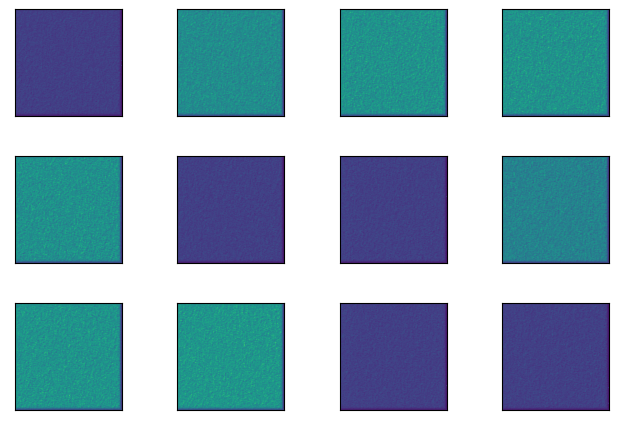

In [17]:
generate_random_imgs_conv(model1,12)

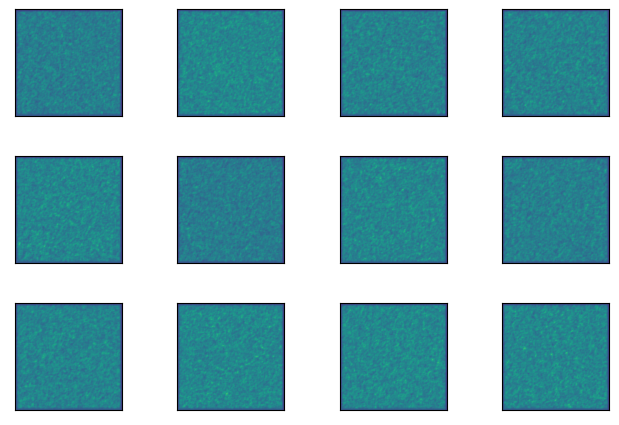

In [18]:
generate_random_imgs_conv(model2,12)

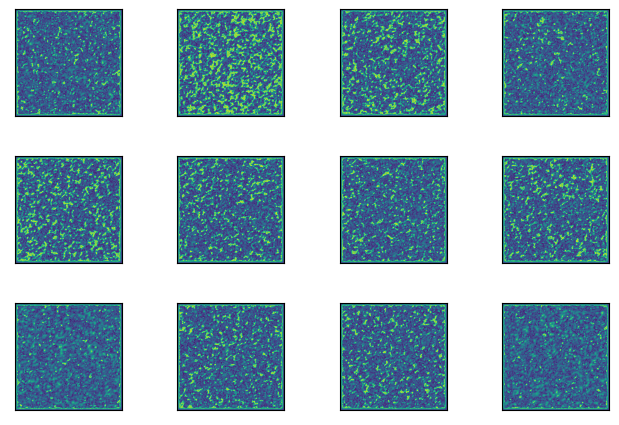

In [19]:
generate_random_imgs_conv(model3,12)

# Latent Space Visualization

In [20]:
def visualize2d_interactive(data,targets,classes):
    
    hover_data = pd.DataFrame({'index':np.arange(len(data)),
                               'label':targets})
    
    hover_data['item'] = hover_data.label.map(classes)
    mapping = umap.UMAP().fit(data)
    umap.plot.output_notebook()
    p = umap.plot.interactive(mapping, labels=targets, hover_data=hover_data, point_size=2,)
    umap.plot.show(p)
    

In [15]:
def visualize2d(data,targets):
    
    mapping = umap.UMAP().fit(data)
    umap.plot.points(mapping, theme='fire');

In [16]:
a = torch.rand(1,320,320)
for i in loader:
    
    a = torch.squeeze(a,axis=1)
    a = torch.cat([a, i])
    
a = a.view(796,1,320,320).to(device)
x = model2.encoder(a)
x = x.view(x.size(0),-1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


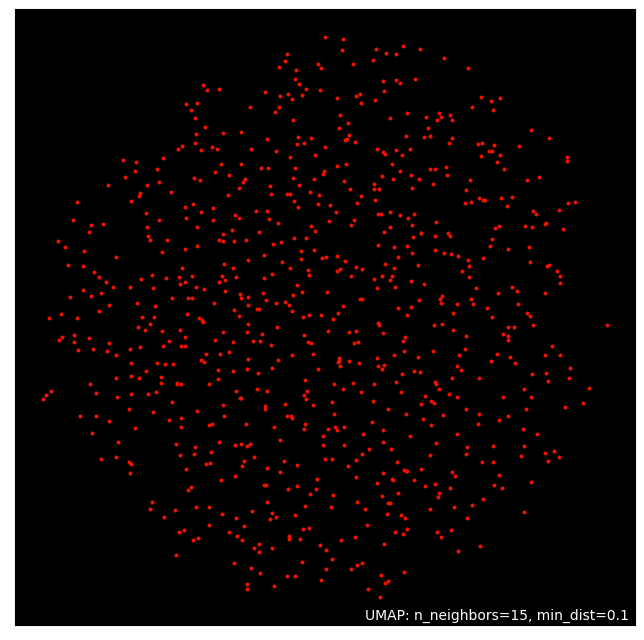

In [17]:
z_mean, z_log_var = model1.mean(x), model1.log_var(x)
encoded = model1.reparameterize(z_mean,z_log_var)
visualize2d(encoded.cpu().detach().numpy(),targets='')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


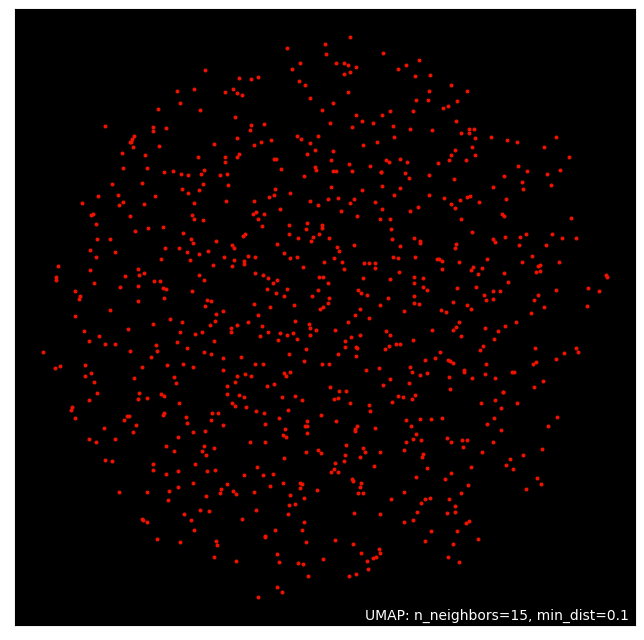

In [18]:
z_mean, z_log_var = model2.mean(x), model2.log_var(x)
encoded = model2.reparameterize(z_mean,z_log_var)
visualize2d(encoded.cpu().detach().numpy(),targets='')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


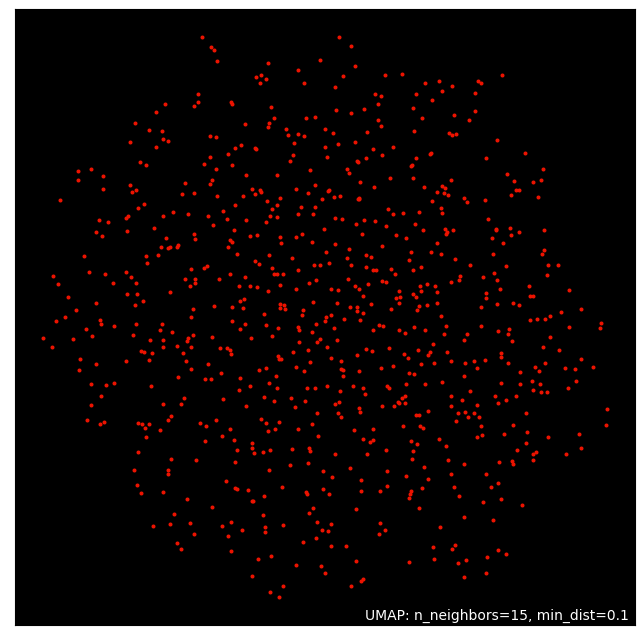

In [19]:
z_mean, z_log_var = model3.mean(x), model3.log_var(x)
encoded = model3.reparameterize(z_mean,z_log_var)
visualize2d(encoded.cpu().detach().numpy(),targets='')

# Regenerate

In [146]:
h5py.File(h5_files[1],"r").keys()
regenerate = np.array(h5py.File(h5_files[1],"r")['1386_HIP-68245_F300M_MASKA335R_sci'])[3:4]
original = np.squeeze(regenerate)

In [147]:
data = regenerate.astype(np.float32)
data = torch.from_numpy(data)
data = data.view(1,1,320,320).to(device)
_,_,_,regenerated = model(data)
result = np.squeeze(regenerated.cpu().detach().numpy())

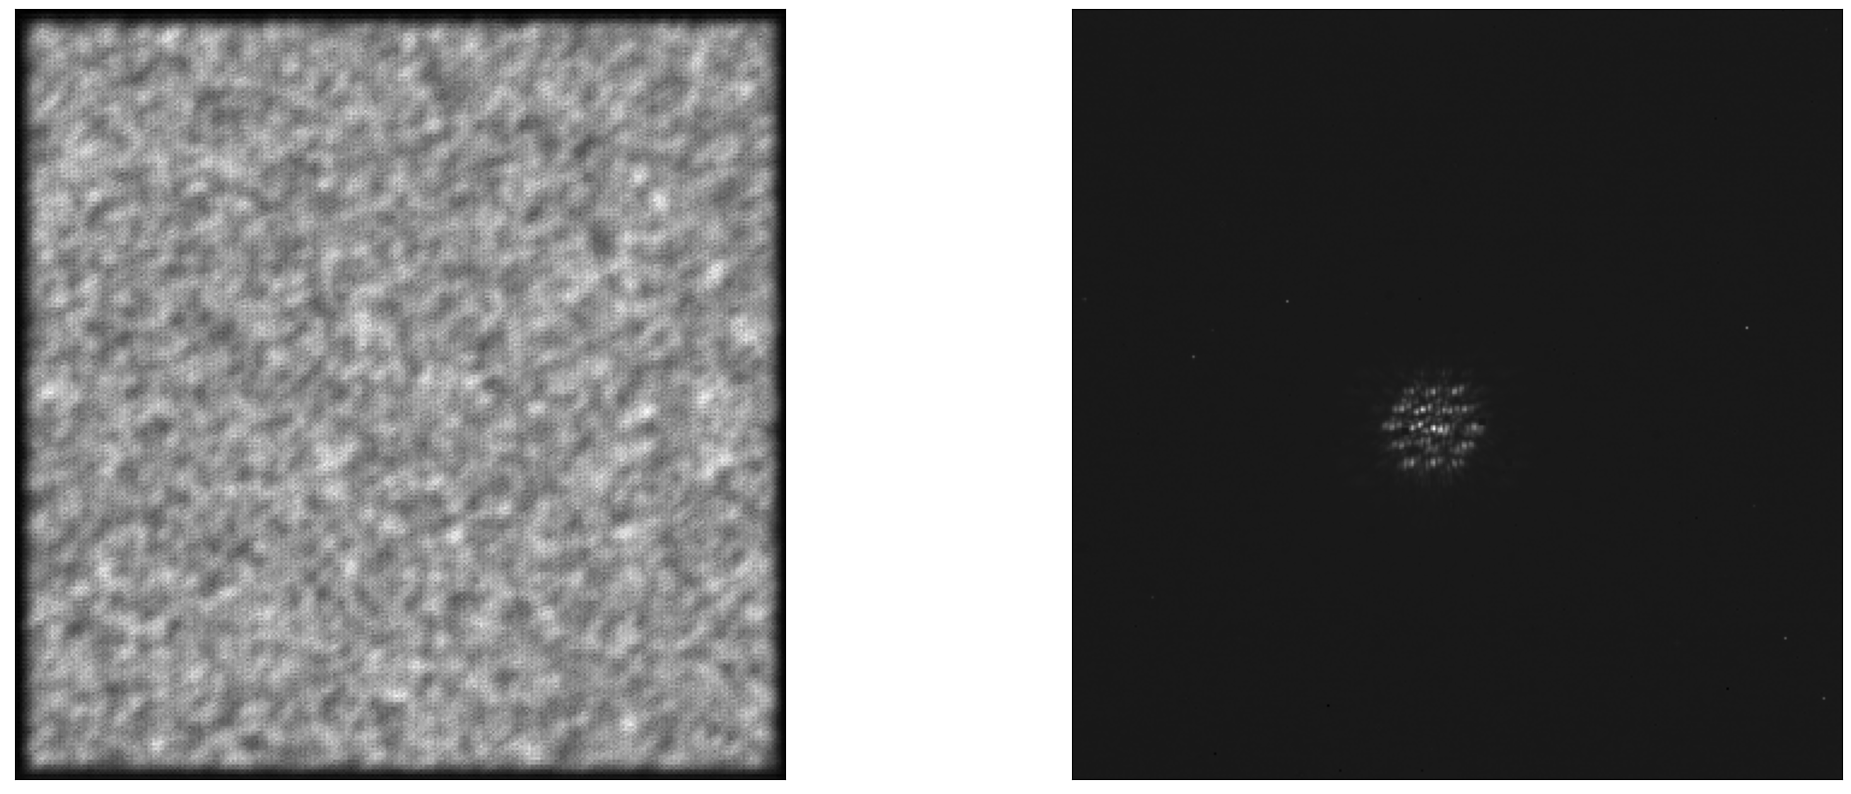

In [148]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(25,10))

for images, row in zip([result,original],axes):
    
    row.imshow(images,cmap='gray')
    row.get_xaxis().set_visible(False)
    row.get_yaxis().set_visible(False)